In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook
from numba import jit, autojit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import eigs, eigsh

In [4]:
x = np.linspace(-100,100,10001)


In [5]:
# Initialise constants for the softcore potential:
v = 2 # set =0 for particle in a box case
n = 2
b = 2
def potential(xk):
    numerator = -v
    denominator = (np.abs(xk)**n + b**n)**(1/n)
    return numerator/denominator

In [6]:
@autojit # try to speed up hamiltonian generation a little
def gen_simple_CFD_Hamiltonian(x_arr):
    """
    Assumes a linearly spaced x-array
    """
    dx2 = -1/(2*(np.abs(x_arr[0]-x_arr[1])**2))
    H = np.zeros((len(x_arr),len(x_arr)))
    for i,val in enumerate(x_arr):
        H[i][i] = potential(val) - 2*dx2
        if i-1>=0:
            H[i][i-1] = dx2
        if (i+1)<len(x_arr):
            H[i][i+1] = dx2
    return H

@autojit
def gen_better_CFD_Hamiltonian(x_arr):
    """
    Assumes a linearly spaced x-array
    """
    dx2 = -1/(2*(np.abs(x_arr[0]-x_arr[1])**2))
    H = np.zeros((len(x_arr),len(x_arr)))
    for i,val in enumerate(x_arr):
        H[i][i] = potential(val) - (5/2)*dx2
        if i-1>=0:
            H[i][i-1] = (4/3)*dx2
        if (i+1)<len(x_arr):
            H[i][i+1] = (4/3)*dx2
        if i-2>=0:
            H[i][i-2] = (-1/12)*dx2
        if (i+2)<len(x_arr):
            H[i][i+2] = (-1/12)*dx2
    return H

@autojit
def gen_simple_FFD_Hamiltonian(x_arr):
    """
    Assumes a linearly spaced x-array
    """
    dx2 = -1/(2*(np.abs(x_arr[0]-x_arr[1])**2))
    H = np.zeros((len(x_arr),len(x_arr)))
    for i,val in enumerate(x_arr):
        H[i][i] = potential(val) + dx2
        if (i+1)<len(x_arr):
            H[i][i+1] = -2*dx2
        if (i+2)<len(x_arr):
            H[i][i+2] = dx2
    return H

@autojit
def gen_simple_BFD_Hamiltonian(x_arr):
    """
    Assumes a linearly spaced x-array
    """
    dx2 = -1/(2*(np.abs(x_arr[0]-x_arr[1])**2))
    H = np.zeros((len(x_arr),len(x_arr)))
    for i,val in enumerate(x_arr):
        H[i][i] = potential(val) + dx2
        if (i-1)>=0:
            H[i][i-1] = -2*dx2
        if (i-2)>=0:
            H[i][i-2] = dx2
    return H

In [7]:
H = gen_better_CFD_Hamiltonian(x)
H = csc_matrix(H) # convert to sparse storage

In [8]:
# biggest_abs_val = eigs(H,k=1)[0][0]
biggest_abs_val = 60
eig_vals,eig_vecs = eigsh(H, k=10, sigma=-biggest_abs_val)
#pairs = eigs(H, k=len(x)-2) # assigns pairs to be a tuple with 2 elements; eigenvalues and eigenvectors
#eig_vals = [x for x,y in sorted(zip(*pairs))] # *pairs unpacks pairs into two arrays
#eig_vecs = [y for x,y in sorted(zip(*pairs))]

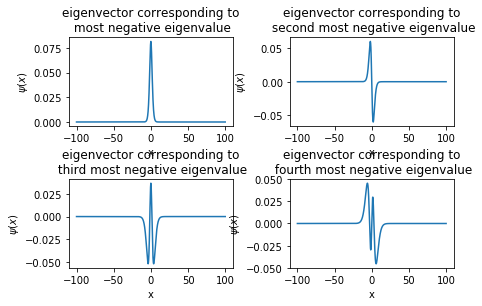

In [9]:
# Note: graphs are set to interactive mode, you can zoom in on sections by clicking the square at the bottom,
#       then selecting an area on a graph.

sns.mpl.pyplot.figure()
sns.mpl.pyplot.subplot(221)
sns.mpl.pyplot.plot(x,eig_vecs[:,0])
sns.mpl.pyplot.ylabel('$\psi(x)$')
sns.mpl.pyplot.xlabel('x')
sns.mpl.pyplot.title('eigenvector corresponding to\n most negative eigenvalue')
sns.mpl.pyplot.subplot(222)
sns.mpl.pyplot.plot(x,eig_vecs[:,1])
sns.mpl.pyplot.ylabel('$\psi(x)$')
sns.mpl.pyplot.xlabel('x')
sns.mpl.pyplot.title('eigenvector corresponding to\n second most negative eigenvalue')
sns.mpl.pyplot.subplot(223)
sns.mpl.pyplot.plot(x,eig_vecs[:,2])
sns.mpl.pyplot.ylabel('$\psi(x)$')
sns.mpl.pyplot.xlabel('x')
sns.mpl.pyplot.title('eigenvector corresponding to\n third most negative eigenvalue')
sns.mpl.pyplot.subplot(224)
sns.mpl.pyplot.plot(x,eig_vecs[:,3])
sns.mpl.pyplot.ylabel('$\psi(x)$')
sns.mpl.pyplot.xlabel('x')
sns.mpl.pyplot.title('eigenvector corresponding to\n fourth most negative eigenvalue')

plt.subplots_adjust(top=0.9, bottom=0.1, left=0.10, right=0.99, hspace=0.6,
                    wspace=0.35)

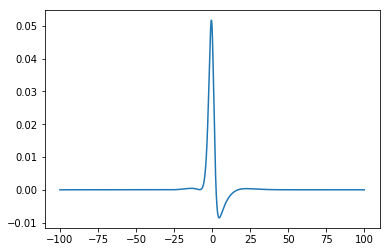

In [10]:
@autojit
def expectation_wave(evals, evecs):
    probs = np.abs(evals)**2
    probs /= np.sum(probs)
    scaled_evecs = probs*evecs
    expectation = 0
    for i in range(scaled_evecs.shape[1]):
        expectation += scaled_evecs[:,i]
    return expectation
expectation = expectation_wave(eig_vals,eig_vecs)
plt.figure()
plt.plot(x,expectation)

Text(150,1,'note: all wavefunctions values shifted\nin order to view simultaneously')

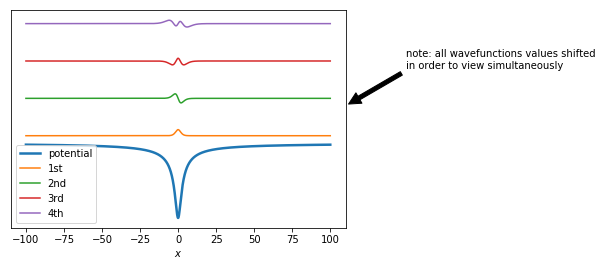

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x,potential(x), label='potential', linewidth=2.5)
ax.plot(x,eig_vecs[:,0]+0.1,label='1st')
ax.plot(x,eig_vecs[:,1]+0.6,label='2nd')
ax.plot(x,eig_vecs[:,2]+1.1,label='3rd')
ax.plot(x,eig_vecs[:,3]+1.6,label='4th')
#plt.ylabel('scaled values (not centred horizontally)')
ax.set_yticklabels([])
ax.set_yticks([])
plt.xlabel('$x$')
ax.legend()
ax.annotate('note: all wavefunctions values shifted\nin order to view simultaneously',
               (110,0.5),
               xytext=(150,1),
               arrowprops=dict(facecolor='black', shrink=0.05))